## **COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset **

About Dataset
Context
X-ray samples of COVID-19 were retrieved from different sources for the unavailability of a large specific dataset. Firstly, a total 1401 samples of COVID-19 were collected using GitHub repository [1] , [2] , the Radiopaedia [3] , Italian Society of Radiology (SIRM) [4] , Figshare data repository websites [5] , [6] . Then, 912 augmented images were also collected from Mendeley instead of using data augmentation techniques explicitly [7] . Finally, 2313 samples of normal and pneumonia cases were obtained from Kaggle

** Find the Data set at : https://www.kaggle.com/datasets/amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset/data**

In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp "/content/drive/MyDrive/Data Science /kaggle.json" ~/.kaggle/kaggle.json

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

### **Loading Data set**

In [5]:
! kaggle datasets download -d amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset

 99% 1.90G/1.91G [00:20<00:00, 121MB/s]
100% 1.91G/1.91G [00:20<00:00, 101MB/s]


In [6]:
!unzip -q /content/covid19-pneumonia-normal-chest-xray-pa-dataset.zip -d /content/

In [51]:
!pip install tensorflow

In [121]:
import time, os
import matplotlib.pyplot as plt
import albumentations as A
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf

from sklearn.metrics import roc_curve
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D,MaxPooling2D, LSTM, BatchNormalization, Dropout, Flatten

In [122]:
covid_path = "/content/covid"
normal_path = "/content/normal"
pneumonia_path = "/content/pneumonia"

### **Checking and Handling Data**

Load a few sample images from each class to visualize and understand the content.

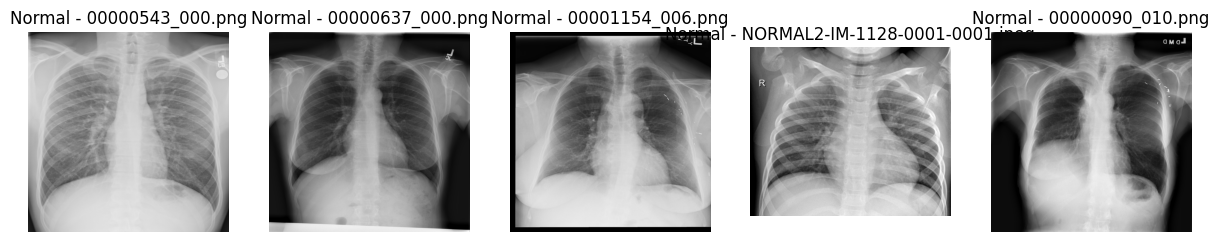

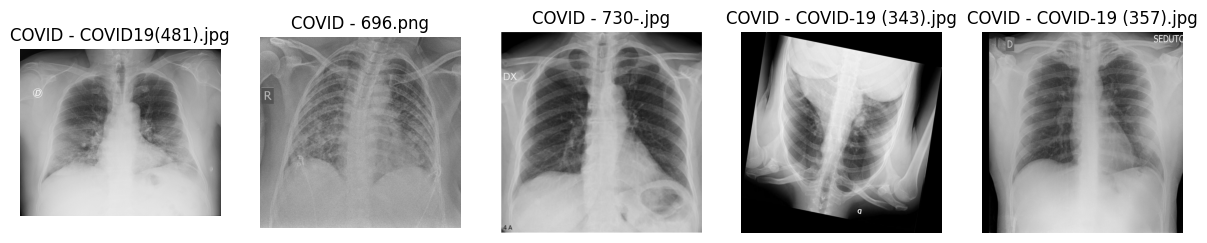

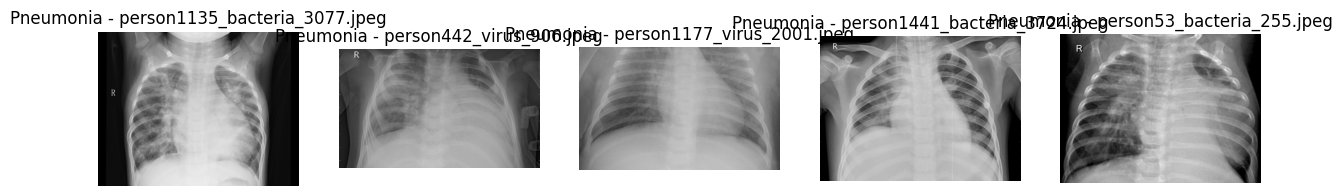

In [123]:
def load_sample_images(folder_path, num_samples=5):
    sample_images = []
    for root, dirs, files in os.walk(folder_path):
        for i, file in enumerate(files):
            if i >= num_samples:
                break
            image_path = os.path.join(root, file)
            image = Image.open(image_path)
            image = image.convert('RGB')
            sample_images.append((file, image))
    return sample_images

def display_sample_images(sample_images, label):
    plt.figure(figsize=(15, 3))
    for i, (file, image) in enumerate(sample_images):
        plt.subplot(1, len(sample_images), i + 1)
        plt.imshow(image)
        plt.title(f"{label} - {file}")
        plt.axis("off")
    plt.show()

# Replace 'path_to_dataset' with the actual path to your dataset and Display image samples
normal_samples = load_sample_images(normal_path)
display_sample_images(normal_samples, 'Normal')


covid_samples = load_sample_images(covid_path)
display_sample_images(covid_samples, 'COVID')


pneumonia_samples = load_sample_images(pneumonia_path)
display_sample_images(pneumonia_samples, 'Pneumonia')

Some images are in png format, some in jpeg format while others are in jpg format.Hence, there is a need to convert images to common format.

In [124]:
def dataset_statistics(folder_path):
    class_counts = {}
    for root, dirs, files in os.walk(folder_path):
        if files:
            class_name = os.path.basename(root)
            class_counts[class_name] = len(files)
    return class_counts

# Replace 'path_to_dataset' with the actual path to your dataset
input_folder = [covid_path, normal_path, pneumonia_path]
print("Dataset Statistics:")
for input in input_folder:
  dataset_stats = dataset_statistics(input)
  for class_name, count in dataset_stats.items():
      print(f"{class_name}: {count} images")

Dataset Statistics:
covid: 2313 images
normal: 2313 images
pneumonia: 2313 images


Since the 3 Groups have equal number of images no need for Handling Data.

In [125]:
from PIL import Image
import os

def convert_images_from_multiple_folders(input_folders, output_folder, output_format='JPEG'):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Iterate over all input folders
    for folder in input_folders:
        # Extract the label from the folder name
        label = os.path.basename(folder)

        # Create a subfolder in the output folder for the current label
        label_output_folder = os.path.join(output_folder, label)
        os.makedirs(label_output_folder, exist_ok=True)

        # Iterate over all files in the current input folder
        for filename in os.listdir(folder):
            input_path = os.path.join(folder, filename)

            # Check if the file is a valid image
            if os.path.isfile(input_path) and any(filename.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.gif']):
                # Open the image
                with Image.open(input_path) as img:
                    # Create the output file path with the new format
                    output_path = os.path.join(label_output_folder, os.path.splitext(filename)[0] + f'.{output_format.lower()}')

                    # Convert and save the image
                    img.convert('RGB').save(output_path, format=output_format)
                    print(f"Converted: {filename} from {folder} -> {output_path}")


# Specify the input folders
input_folders = [covid_path, normal_path, pneumonia_path]

# Create the output folder
output_folder = '/content/output_images'
os.makedirs(output_folder, exist_ok=True)

# Specify the output format
output_format = 'JPEG'

# Call the function
convert_images_from_multiple_folders(input_folders, output_folder, output_format)


Streaming output truncated to the last 5000 lines.
Converted: COVID-19 (605).jpg from /content/covid -> /content/output_images/covid/COVID-19 (605).jpeg
Converted: COVID19(204).jpg from /content/covid -> /content/output_images/covid/COVID19(204).jpeg
Converted: COVID-19 (2).jpg from /content/covid -> /content/output_images/covid/COVID-19 (2).jpeg
Converted: COVID19(275).jpg from /content/covid -> /content/output_images/covid/COVID19(275).jpeg
Converted: COVID19(450).jpg from /content/covid -> /content/output_images/covid/COVID19(450).jpeg
Converted: COVID19(557).jpg from /content/covid -> /content/output_images/covid/COVID19(557).jpeg
Converted: COVID19(82).jpg from /content/covid -> /content/output_images/covid/COVID19(82).jpeg
Converted: COVID19(362).jpg from /content/covid -> /content/output_images/covid/COVID19(362).jpeg
Converted: COVID19(116).jpg from /content/covid -> /content/output_images/covid/COVID19(116).jpeg
Converted: COVID19(154).jpg from /content/covid -> /content/outpu

In [126]:
def dataset_statistics(folder_path):
    class_counts = {}
    for root, dirs, files in os.walk(folder_path):
        if files:
            class_name = os.path.basename(root)
            class_counts[class_name] = len(files)
    return class_counts

# Replace 'path_to_dataset' with the actual path to your dataset
dataset_stats = dataset_statistics('/content/output_images')
print("Dataset Statistics:")
for class_name, count in dataset_stats.items():
    print(f"{class_name}: {count} images")


Dataset Statistics:
covid: 2242 images
pneumonia: 2313 images
normal: 2313 images


Number of covid images gets reduced, maybe due to Unsupported Formats, Invalid Images, Duplicates etc.

In [127]:
def load_imgs(path,urls,target):
  images=[]
  labels=[]
  for i in range(len(urls)):
    #img_path=path + urls[i]
    img = cv2.imread(os.path.join(path, urls[i]))
    try:
      img = cv2.resize(img,(64,64))
    except:
      break
    images.append(img)
    labels.append(target)
  return images,labels

In [160]:
path_c="/content/output_images/covid"
path_n="/content/output_images/normal"
path_p="/content/output_images/pneumonia"

Creating a path to all folders

In [161]:
urls_c = os.listdir("/content/output_images/covid")
urls_n = os.listdir("/content/output_images/normal")
urls_p = os.listdir("/content/output_images/pneumonia")

Listing Directories is getting the Unique paths of each image.

In [162]:
normal_imgs, normal_targets = load_imgs(path_n,urls_n,0)
covid_imgs, covid_targets = load_imgs(path_c,urls_c,1)
pneumonia_imgs, pneumonia_targets = load_imgs(path_p,urls_p,2)

Segregating Path to images and their target labels.

In [163]:
normal_imgs = np.asarray(normal_imgs)
covid_imgs = np.asarray(covid_imgs)
pneumonia_imgs = np.asarray(pneumonia_imgs)

Converting the images to Array format for easy Model Training.

In [164]:
print(covid_imgs.shape)
print(normal_imgs.shape)
pneumonia_imgs.shape

(2242, 64, 64, 3)
(2313, 64, 64, 3)


(2313, 64, 64, 3)

In [165]:
data = np.r_[normal_imgs, covid_imgs, pneumonia_imgs]
data.shape

(6868, 64, 64, 3)

In [166]:
target = np.r_[normal_targets, covid_targets, pneumonia_targets]
target.shape

(6868,)

In [167]:
data=data/128.0

Normalizing Data to get values between 0 and 1.

**Splitting Data into Train and test**

In [168]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

### **Model Training**

In [169]:
model=Sequential([
     Conv2D(32,3,input_shape=(64,64,3),activation='relu'),
     MaxPooling2D(),

     Conv2D(16,3,activation='relu'),
     MaxPooling2D(),

     Conv2D(16,3,activation='relu'),
     MaxPooling2D(),

     Flatten(),
     Dense(32,activation='relu'),
     Dense(3,activation='softmax')
 ])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 29, 29, 16)        4624      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 14, 14, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 12, 12, 16)        2320      
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 6, 6, 16)         

In [170]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [171]:
history=model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
43/43 [==============================] - 4s 24ms/step - loss: 0.8763 - accuracy: 0.6170 - val_loss: 0.6159 - val_accuracy: 0.7598
Epoch 2/20
43/43 [==============================] - 1s 14ms/step - loss: 0.5787 - accuracy: 0.7772 - val_loss: 0.4902 - val_accuracy: 0.8195
Epoch 3/20
43/43 [==============================] - 1s 14ms/step - loss: 0.4631 - accuracy: 0.8338 - val_loss: 0.4395 - val_accuracy: 0.8493
Epoch 4/20
43/43 [==============================] - 1s 13ms/step - loss: 0.3851 - accuracy: 0.8657 - val_loss: 0.3529 - val_accuracy: 0.8952
Epoch 5/20
43/43 [==============================] - 1s 13ms/step - loss: 0.3471 - accuracy: 0.8895 - val_loss: 0.3147 - val_accuracy: 0.9047
Epoch 6/20
43/43 [==============================] - 1s 13ms/step - loss: 0.3028 - accuracy: 0.8995 - val_loss: 0.2957 - val_accuracy: 0.9083
Epoch 7/20
43/43 [==============================] - 1s 13ms/step - loss: 0.3041 - accuracy: 0.8995 - val_loss: 0.3255 - val_accuracy: 0.8923
Epoch 8/20
43

In [172]:
y_pred=model.predict(x_test)
y_pred[:5]

43/43 [==============================] - 0s 3ms/step


array([[1.94466543e-06, 2.80754466e-05, 9.99969959e-01],
       [1.73827706e-04, 2.62369663e-02, 9.73589182e-01],
       [9.21566427e-01, 2.12782845e-02, 5.71552701e-02],
       [1.02478623e-06, 9.99994874e-01, 4.04570119e-06],
       [1.03138536e-01, 1.26186386e-01, 7.70675063e-01]], dtype=float32)

In [173]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:5]

[2, 2, 0, 1, 2]

In [174]:
y_test[:5]

array([2, 2, 0, 1, 2])

43/43 [==============================] - 0s 2ms/step


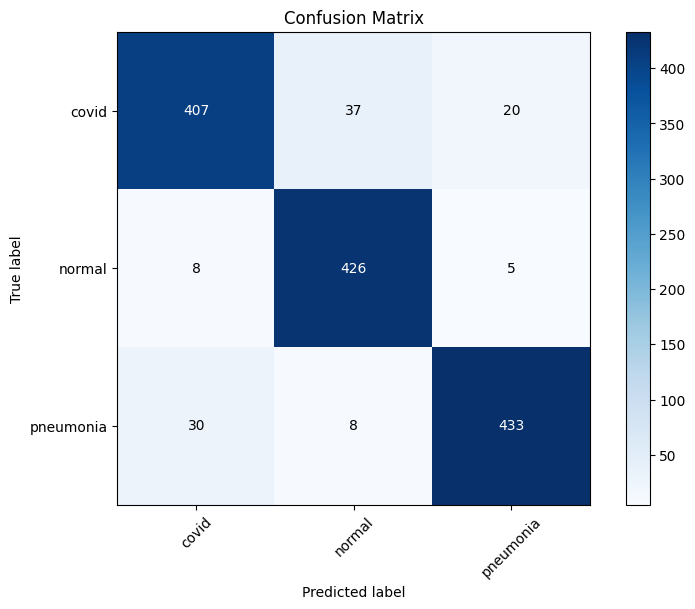

In [175]:
predictions = np.argmax(model.predict(x_test), axis=-1)

class_names = ['covid', 'normal', 'pneumonia']
class_indices = {class_name: i for i, class_name in enumerate(class_names)}
true_labels_indices = []

for label in y_test:
    true_label_str = class_names[label]  # Convert integer label to string
    true_labels_indices.append(class_indices[true_label_str])
true_labels_indices = [class_indices[class_names[label]] for label in y_test]

conf_matrix = confusion_matrix(true_labels_indices, predictions)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [176]:
classification_report_result = classification_report(y_test, predictions, target_names=class_names, output_dict=True, digits=4)

classification_report_result

{'covid': {'precision': 0.9146067415730337,
  'recall': 0.8771551724137931,
  'f1-score': 0.8954895489548954,
  'support': 464},
 'normal': {'precision': 0.9044585987261147,
  'recall': 0.9703872437357631,
  'f1-score': 0.9362637362637363,
  'support': 439},
 'pneumonia': {'precision': 0.9454148471615721,
  'recall': 0.9193205944798302,
  'f1-score': 0.9321851453175458,
  'support': 471},
 'accuracy': 0.9213973799126638,
 'macro avg': {'precision': 0.9214933958202401,
  'recall': 0.9222876702097955,
  'f1-score': 0.9213128101787259,
  'support': 1374},
 'weighted avg': {'precision': 0.921925215388466,
  'recall': 0.9213973799126638,
  'f1-score': 0.9210961676706083,
  'support': 1374}}

In [177]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [178]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

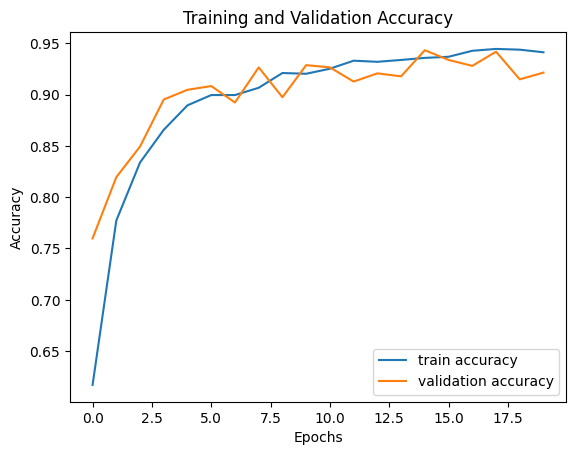

In [179]:
plt.plot(acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

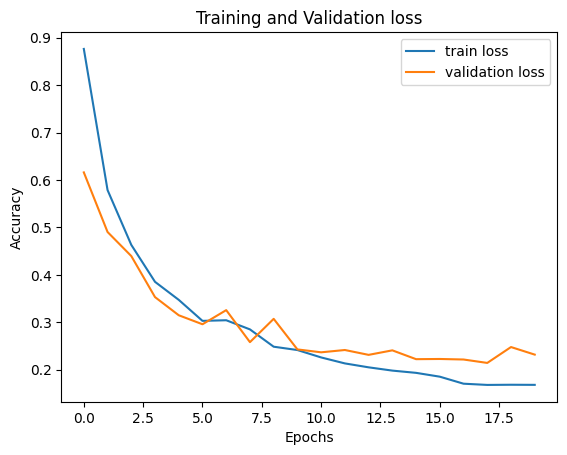

In [180]:
plt.plot(loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation loss')
plt.show()